In [1]:
# For data prep
import numpy as np
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

# For PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
import bisect

# For plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# For writeup
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [2]:
with create_engine('sqlite:///ulam.db').connect() as conn:
    df_ing = pd.read_sql("""
    SELECT * FROM rekado
    """, conn)
    
display(df_ing)

,dish_name,yeast,wrapper,worcestershire_sauce,winged_bean,vinegar,turmeric,tomato,tofu,toasted_rice_powder,...,shrimp,pineapple,water,salt,rice,pork,corn,chicken,beef,banana
0,Sinarsahang Manok,0.0,0.0,0.0,0.0,0.0000,0.0,2.5,0.0,0.0,...,0.0,0.0,1.50,0.000000,0.0,0.0,0.000,680.389364,0.000000,0.0
1,Pinoy Chicken Curry Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.00,0.000000,0.0,0.0,0.000,907.185819,0.000000,0.0
2,Ketchup Fried Chicken,0.0,0.0,0.0,0.0,0.3125,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.0,0.000,3.000000,0.000000,0.0
3,Chicken Barbecue,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,2.000000,0.0,0.0,0.000,4.000000,0.000000,0.0
4,Chicken Paksiw Recipe,0.0,0.0,0.0,0.0,0.5000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.00,1.000000,0.0,0.0,0.000,453.592909,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,Papaitan Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,8.00,0.156250,0.0,0.0,0.000,0.000000,226.796455,0.0
278,Morcon Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.005208,0.0,0.0,0.000,0.000000,907.185819,0.0
279,Beef Mechado Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,1.0,0.0,0.0,...,0.0,0.0,1.00,1.000000,0.0,0.0,0.000,0.000000,907.185819,0.0
280,Bulalo Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,4.25,0.000000,0.0,0.0,1.125,0.000000,907.185819,0.0


# Data Prep

In [3]:
def drop_features(data, irrelevant_cols, skip_cols, p):
    """
    Drop features given a variance threshold

    Parameters
    ----------
    data : dataframe
        dataframe from which the columns will be dropped. May contain
    a mix of numeric and categorical columns. By default, categorical
    columns are label-encoded before getting the variance of the columns.

    irrelevant_cols : list
        list of column names. Column names in this list will be dropped
    permanently.

    skip_cols : list
        list of column names. Column names in this list will be kept by
    default and will not undergo variance thresholding.

    p : float
        variance threshold for dropping. A p = 0.01 would mean dropping
    columns where 99% of the values are similar.

    Returns
    -------
        dataframe in its original format, whose columns that did not
    satisfy the p threshold were dropped

    """
    orig_data = data.copy(deep=True)
    if irrelevant_cols is not None:
        print(f"Dropping irrelevant columns:\n{irrelevant_cols}")
        data = orig_data.drop(irrelevant_cols, axis=1)
    if skip_cols is not None:
        print(f"\nSkipping the following columns:\n{skip_cols}")
        data = data.drop(skip_cols, axis=1)

    num_data = pd.DataFrame(data.select_dtypes(include=np.number))
    cat_data = pd.DataFrame(data.select_dtypes(exclude=np.number))

    if cat_data.shape[1] != 0:
        cat_data = cat_data.apply(LabelEncoder().fit_transform)
        transformed_data = pd.concat([num_data, cat_data], axis=1)
    else:
        transformed_data = num_data

    # threshold=0.01 means dropping the column where 99% of values are similar.
    thresh = VarianceThreshold(threshold=p)
    thresh.fit_transform(transformed_data)
    ind = thresh.get_support(indices=True)
    cols_kept = list(transformed_data.columns[ind])
    cols_dropped = list(set(transformed_data.columns)-set(cols_kept))

    print(f"\nGiven threshold = {p}, the following columns"
          f" were dropped:\n{cols_dropped}")
    
    if skip_cols is not None:
        return orig_data[skip_cols + cols_kept]
    
    return orig_data[cols_kept]

def fix_dtypes(data):
    """Fix datatypes of the dataframe

    Parameters
    ----------
    data : dataframe
        dataframe from which the columns will be appropriately
    converted into their correct data types. May contain a mix of numeric
    and categorical columns.

    """
    df = data.copy(deep=True)
    df = df.convert_dtypes()
    for i in df.columns:
        if '_dt' in i:
            df[i] = pd.to_datetime(df[i], errors='coerce')
    return df

In [26]:
fixed_df = fix_dtypes(df_ing)
dropped_df = drop_features(df_ing, irrelevant_cols=['dish_name'], skip_cols=None, p=0)
X = np.array(dropped_df, dtype=float)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Dropping irrelevant columns:
['dish_name']

Given threshold = 0, the following columns were dropped:
['cucumber', 'leeks', 'turmeric', 'glutinous_rice', 'pea', 'pineapple_juice']


# SVD

In [50]:
def truncated_svd(X, thresh=0.90):
    """Perform singular value decomposition on a design matrix X"""
    
    q, s, p = np.linalg.svd(X, full_matrices=True)
    Q = q
    S = np.diag(s)
    P = p.T
    NSSD = (s / np.sqrt(np.sum(s**2)))**2
    
    ind = bisect.bisect(NSSD.cumsum(), thresh) +1
    print(f'\nTo achieve at least {thresh*100}%, {ind} PCs are required.')
    
    return Q, S, P, NSSD

def project_svd(q, s, k):
    """Project the design matrix on to the first k singular vectors"""
    
    return q[:,:k].dot(s[:k,:k])

def plot_var(variance_explained, num_components):
    """
    Plot the individual and cumulative variance explained of the resulting PCs.

    Parameters
    ----------
    variance_explained : array
        Eigenvalues of the PCs.
    num_components : int or float
        Number of components to keep; to be imposed on with a horizontal
    dashed line.
    species_str : str
        String to be placed in the plot title.

    """
    var_ind = pd.DataFrame(zip(range(1, len(variance_explained)+1),
                                   ['Individual']*len(variance_explained),
                                   variance_explained),
                               columns=['SV', 'Contribution', 'Value'])
    var_cum = pd.DataFrame(zip(range(1, len(variance_explained)+1),
                                   ['Cumulative']*len(variance_explained),
                                   variance_explained.cumsum()),
                               columns=['SV', 'Contribution', 'Value'])
    var = pd.concat([var_ind, var_cum], axis=0)
    value = var['Value']*100
    var['Contribution %'] = (value).round(2).astype(str) + '%'
    var['Value'] = var['Value']*100

    fig = px.line(var, x='SV', y='Value', color='Contribution',
                  hover_data={'SV': False,
                              'Contribution': False,
                              'Value': False,
                              'Contribution %': True},
                  markers=True, color_discrete_map={'Individual': '#8F0A1B',
                                                    'Cumulative': '#104C6B'})
    fig.update_layout(
            xaxis_title="<b>Number of SV</b>",
            yaxis_title="<b>Variance Explained</b>",
            title={'text': f'<b>Chosen SVs to '
                   f'Reach 90% Cumulative Variance Explained</b>',
                   'xanchor': 'center',
                   'yanchor': 'top',
                   'x': 0.5},
            margin=dict(l=0, r=0, t=100, b=0),
            font={'size': 14, 'color': '#333136'},
            plot_bgcolor='white',
            yaxis_range=[0, 100],
            hovermode="x",
            height=500,
            width=800)
    fig.add_shape(
            type='line',
            yref='paper',
            y0=0,
            y1=1,
            xref='x',
            x0=num_components,
            x1=num_components,
            line=dict(
                color='#333136',
                dash='dash',
                width=2))
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#EEF4ED')
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        title='<b>Contribution</b>'
    ))

    return fig

In [52]:
q, s, p, nssd = truncated_svd(X)
plot_var(nssd, 60)


To achieve at least 90.0%, 60 PCs are required.


In [53]:
X_new = project_svd(q, s, 60)
feature_names = dropped_df.columns
weights_df = pd.DataFrame(p, index=feature_names)
weights_df.columns = ['SV'+str(c+1) for c in weights_df.columns]
weights_df = weights_df.iloc[:,:num]
weights_df

,SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,...,SV50,SV51,SV52,SV53,SV54,SV55,SV56,SV57,SV58,SV59
yeast,-0.002403,-0.004773,0.004080,-0.002764,-0.001896,0.004624,-0.021111,0.013710,-0.025298,0.021925,...,0.018387,0.002139,0.009431,0.008824,-0.049502,0.007933,0.029602,0.024065,0.052074,-0.046443
wrapper,-0.015338,0.015584,0.012802,-0.002763,-0.000418,0.014742,-0.065729,0.051591,0.015981,-0.069661,...,0.053560,0.008492,-0.310549,-0.005533,-0.064960,-0.032950,0.029734,-0.146654,0.066294,-0.016839
worcestershire_sauce,-0.009521,-0.000061,0.013076,-0.000535,-0.009177,-0.003211,-0.029946,-0.016476,-0.024509,-0.022969,...,0.088646,-0.016853,-0.029911,-0.091708,0.005832,-0.051234,0.015906,-0.028511,-0.032802,-0.061044
winged_bean,-0.008779,0.003726,-0.022449,0.006739,-0.003181,-0.000192,0.004246,0.008007,-0.020153,0.017945,...,-0.025604,0.031577,0.027524,-0.040319,0.021391,-0.029198,-0.000508,0.052962,-0.020708,-0.110444
vinegar,-0.116846,-0.122291,-0.036176,-0.131102,0.039716,0.001105,0.106531,0.069120,-0.097218,0.067874,...,-0.083012,0.168497,-0.084384,0.197693,-0.024853,0.076789,0.053772,-0.032308,0.056598,0.177027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pork,-0.230481,-0.201200,0.260732,-0.001460,-0.056777,-0.099814,-0.291894,0.288859,0.063261,0.348667,...,-0.040753,0.085743,0.017898,-0.064967,-0.032282,0.028270,-0.029182,-0.005401,-0.078502,0.073715
corn,-0.005150,-0.005755,0.000389,0.013557,0.001948,0.015866,-0.024891,-0.038544,0.036503,-0.061973,...,0.087109,-0.009691,0.050903,-0.090043,0.046670,-0.060181,-0.033297,0.041883,-0.007530,-0.025494
chicken,-0.327709,0.436494,-0.704683,-0.044670,0.100934,0.083269,-0.004068,0.168682,-0.049128,0.166905,...,-0.005495,0.102740,0.013979,-0.023307,0.003496,0.054171,-0.015698,0.016800,-0.029274,-0.007662
beef,-0.054777,-0.047489,0.017223,0.099914,-0.042626,0.075339,-0.045415,-0.166767,0.017644,-0.185408,...,-0.044768,-0.080389,-0.152545,0.110243,-0.071589,0.059116,0.071744,-0.025815,-0.000542,0.026127


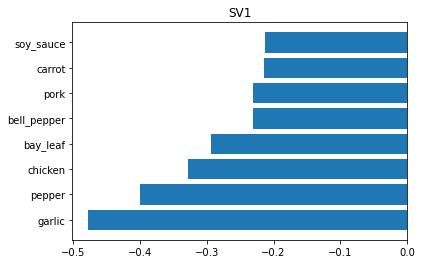

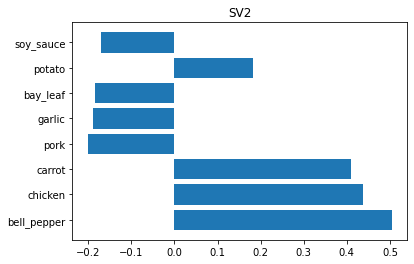

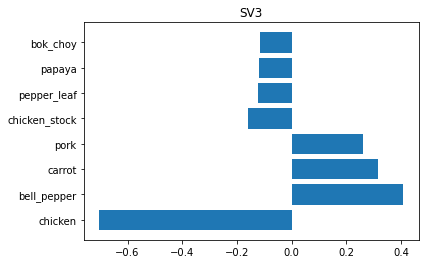

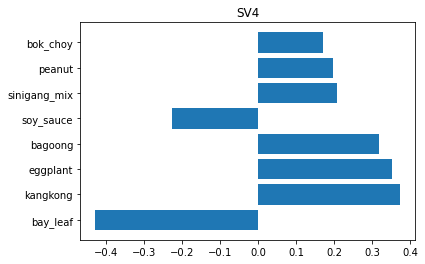

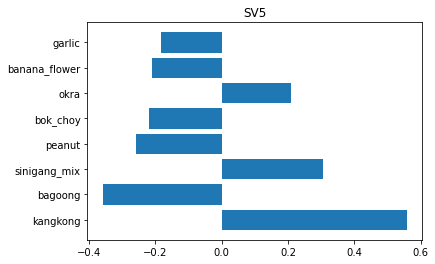

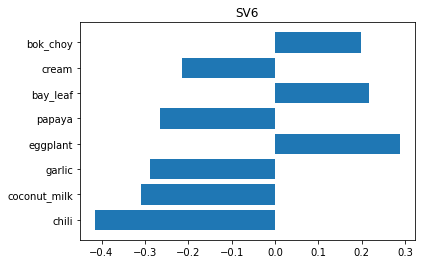

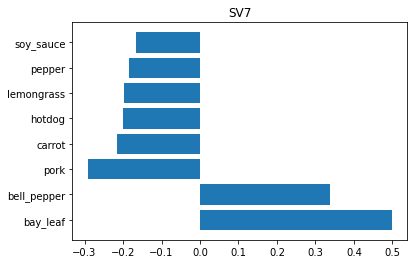

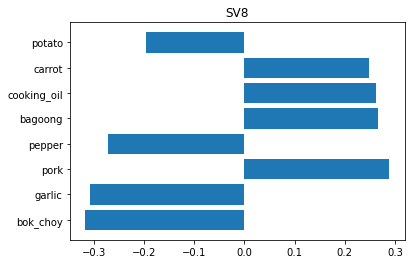

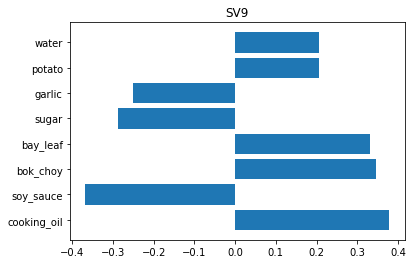

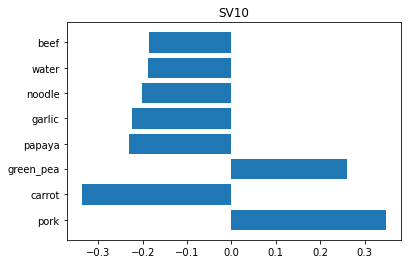

In [56]:
for i in range(10):
    fig, ax = plt.subplots()
    pc = weights_df.iloc[:,i].reset_index()
    pc.columns = ['ing', 'loading']
    pc['abs_loading'] = np.abs(pc['loading'])
    pc = pc.sort_values('abs_loading', ascending=False).head(8)
    ax.barh(pc['ing'], pc['loading'])
    ax.set_title(f'SV{i+1}')

# Representative-based Clustering

In [168]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedians import kmedians
from scipy.spatial.distance import euclidean, cityblock
from sklearn.base import clone
from sklearn.metrics import calinski_harabasz_score, silhouette_score

def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Cluster centroids
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    datapoint_ss = []
    total = np.bincount(y) # 3 0s, 4 1s, 3 2s
    for X_, y_ in zip(X, y):
        num = dist(X_, centroids[y_])**2
        den = 2*total[y_]
        datapoint_ss += [num/den] # compile sum of squares for each datapoint
    return sum(datapoint_ss)

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Cluster centroids
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(random_state)
    W_bar = pooled_within_ssd(X, y, centroids, dist)

    diff = []
    for i in range(b):
        X_null = rng.uniform(low=X.min(0),
                             high=X.max(0),
                             size=X.shape)
        clusterer = clusterer.fit(X_null)
        pred_null = clusterer.predict(X_null)
        centroids_null = clusterer.cluster_centers_
        W_ik = pooled_within_ssd(X_null, pred_null, centroids_null, dist)
        diff += [np.log(W_ik) - np.log(W_bar)]

    gs = np.sum(diff)/b
    gs_std = np.std(diff)
    
    return gs, gs_std

def gap_statistic_kmedians(X, y, centroids, b):
    """Compute the gap statistic for a k-medians clusterer
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Cluster centroids
    b : int
        Number of realizations for the reference distribution
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    # rng = np.random.default_rng(1337)
    np.random.seed(1337) # use this instead
    dist = cityblock
    W_bar = pooled_within_ssd(X, y, centroids, dist)

    diff = []
    for i in range(b):
        X_null = np.random.uniform(low=X.min(0), # not rng.uniform() anymore
                                   high=X.max(0),
                                   size=X.shape)
        clusterer = kmedians(X_null, X_null[:centroids.shape[0], :]).process()
        pred_null = clusterer.predict(X_null) # predicted labels
        centroids_null = clusterer.get_medians()
        W_ik = pooled_within_ssd(X_null, pred_null, centroids_null, dist)
        diff += [np.log(W_ik) - np.log(W_bar)]

    gs = np.sum(diff)/b
    gs_std = np.std(diff)
    
    return gs, gs_std

def inertia_(X, y, centroids, dist):
    """Compute within-cluster sum of squares around the cluster centroid
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Cluster centroids
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    datapoint_ss = []
    for X_, y_ in zip(X, y):
        # compile sum of squares for each datapoint
        datapoint_ss += [dist(X_, centroids[y_])**2] 
    return sum(datapoint_ss)

def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    """For a given range of k, perform a given clustering method and
    return relevant results"""
    
    ys = []
    centers = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    
    dist=euclidean
    for k in range(k_start, k_stop+1):
        
        # Perform clustering
        clusterer_k = clone(clusterer)
        clusterer_k.set_params(n_clusters=k)
        y_pred = clusterer_k.fit_predict(X)
        center = clusterer_k.cluster_centers_
        
        # Collect ys and centers
        ys += [y_pred]
        centers += [center]
        keys = ['ys', 'centers']
        values = [ys, centers]
        res_dict = dict(zip(keys, values))

        # Collect internal validation metrics
        inertia = clusterer_k.inertia_ ## SS to centroids
        ch = calinski_harabasz_score(X, y_pred) ## Calinski-Hanbaz
        sc = silhouette_score(X, y_pred) ## Sillhouete score
        gap = gap_statistic(X=X, y=y_pred, centroids=center, b=5, # Gap statistic
                            clusterer=clusterer_k, dist=dist,
                            random_state=1337) 
        inertias += [inertia]
        chs += [ch]
        scs += [sc]
        gss += [gap[0]]
        gssds += [gap[1]]

        keys = ['inertias', 'chs', 'scs', 'gss', 'gssds']
        values = [inertias, chs, scs, gss, gssds]
        internal_dict = dict(zip(keys, values))

        # Collect external validation metrics
        if actual is not None:
            p = purity(y_true=actual, y_pred=y_pred)
            ami = adjusted_mutual_info_score(labels_true=actual, 
                                             labels_pred=y_pred)
            ar = adjusted_rand_score(labels_true=actual, labels_pred=y_pred)       
            ps += [p]
            amis += [ami]
            ars += [ar]

            keys = ['ps', 'amis', 'ars']
            values = [ps, amis, ars]
            external_dict = dict(zip(keys, values)) 
        else:
            external_dict = {}

    res = {**res_dict, **internal_dict, **external_dict}
    
    return res

def plot_clusters(X, ys, x_num, y_num):
    """Plot clusters given the design matrix and cluster labels"""
    X = X[:,(x_num-1):(y_num)]
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=100, sharex=True, sharey=True, 
                           figsize=(7,4), subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    for k,y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k%k_mid-2].scatter(*zip(*X), c=y,alpha=0.8)
            ax[0][k%k_mid-2].set_title('$k=%d$'%k)
        else:
            ax[1][k%k_mid].scatter(*zip(*X), c=y, alpha=0.8)
            ax[1][k%k_mid].set_title('$k=%d$'%k)
    return ax

def plot_internal(inertias, chs, scs, gss, gssds):
    """Plot internal validation values"""
    
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.errorbar(ks, gss, gssds, fmt='-go', label='Gap statistic')
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Gap statistic/Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

def cluster_range_kmedians(X, k_start, k_stop, actual=None):
    """For a given range of k, perform a k-median clustering and
    return relevant results"""
    
    ys = []
    centers = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    
    dist = cityblock
    for k in range(k_start, k_stop+1):
        
        # Perform clustering
        clusterer_k = kmedians(X, X[:k,:], ccore=True).process()
        center = np.array(clusterer_k.get_medians())
        y_pred = clusterer_k.predict(X)
        # clusters = clusterer_k.get_clusters() 
        # y_pred = np.zeros(X.shape[0], dtype=int)
        # for cluster, ind in enumerate(clusters):
        #     y_pred[ind] = cluster
        
        # Collect ys and centers
        ys += [y_pred]
        centers += [center]
        keys = ['ys', 'centers']
        values = [ys, centers]
        res_dict = dict(zip(keys, values))
        
        # Collect internal validation metrics
        inertia = inertia_(X=X, y=y_pred, ## SS to centroids
                           centroids=center, dist=dist) 
        ch = calinski_harabasz_score(X, y_pred) ## Calinski-Hanbaz
        sc = silhouette_score(X, y_pred) ## Sillhouete score
        gap = gap_statistic_kmedians(X=X, y=y_pred, centroids=center, b=5) 
        inertias += [inertia]
        chs += [ch]
        scs += [sc]
        gss += [gap[0]]
        gssds += [gap[1]]
        keys = ['inertias', 'chs', 'scs', 'gss', 'gssds']
        values = [inertias, chs, scs, gss, gssds]
        internal_dict = dict(zip(keys, values))

        # Collect external validation metrics
        if actual is not None:
            p = purity(y_true=actual, y_pred=y_pred)
            ami = adjusted_mutual_info_score(labels_true=actual, 
                                             labels_pred=y_pred)
            ar = adjusted_rand_score(labels_true=actual,
                                     labels_pred=y_pred)       
            ps += [p]
            amis += [ami]
            ars += [ar]

            keys = ['ps', 'amis', 'ars']
            values = [ps, amis, ars]
            external_dict = dict(zip(keys, values)) 
        else:
            external_dict = {}
    
    res = {**res_dict, **internal_dict, **external_dict}
    
    return res

def fix_dendro(Z):
    fig, ax = plt.subplots()
    dn = dendrogram(Z, ax=ax, p=5, truncate_mode='level')
    ax.set_ylabel(r'$\Delta$')
    return ax

## K-Means

### Perform clustering on transformed matrix

In [149]:
cluster_res = cluster_range(X_new, KMeans(random_state=1337), 2, 7)

### Plot clusters
Interpretation will change depending on the chosen SVs to plot

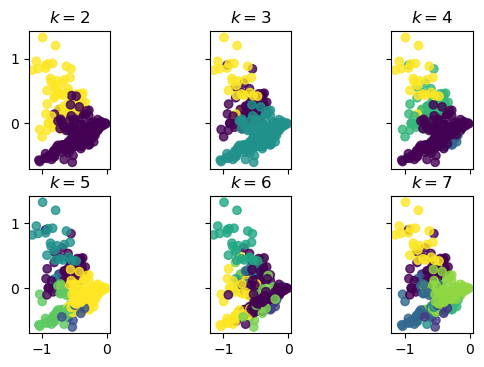

In [150]:
# Visualize SV1 vs. SV2
plot_clusters(X_new, cluster_res['ys'], x_num=1, y_num=2);

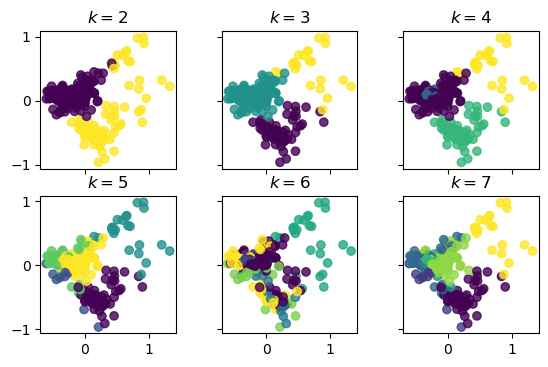

In [151]:
# Visualize SV2 vs. SV3
plot_clusters(X_new, cluster_res['ys'], x_num=2, y_num=3);

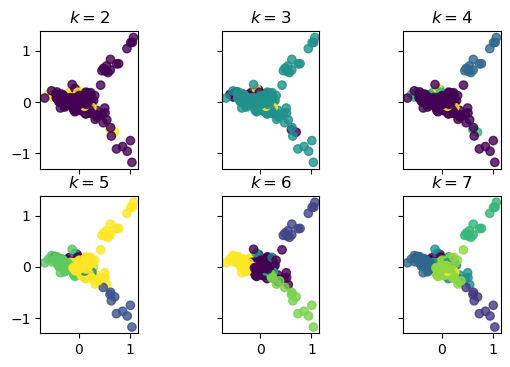

In [152]:
# Visualize SV4 vs. SV5
plot_clusters(X_new, cluster_res['ys'], x_num=4, y_num=5);

### Plot validation metrics

<AxesSubplot:xlabel='$k$', ylabel='SSE/CH'>

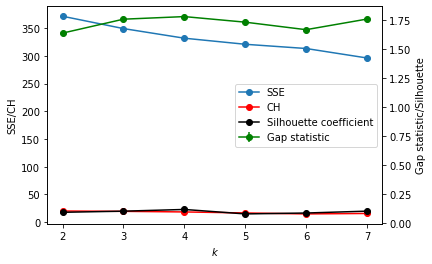

In [153]:
plot_internal(cluster_res['inertias'],
              cluster_res['chs'],
              cluster_res['scs'],
              cluster_res['gss'],
              cluster_res['gssds'])

## K-Medians

### Perform clustering on transformed matrix

In [156]:
cluster_res = cluster_range_kmedians(X_new, k_start=2, k_stop=7)

### Plot clusters
Interpretation will change depending on the chosen SVs to plot

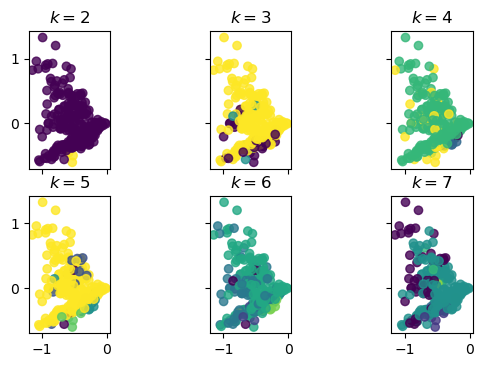

In [157]:
# Visualize SV1 vs. SV2
plot_clusters(X_new, cluster_res['ys'], x_num=1, y_num=2);

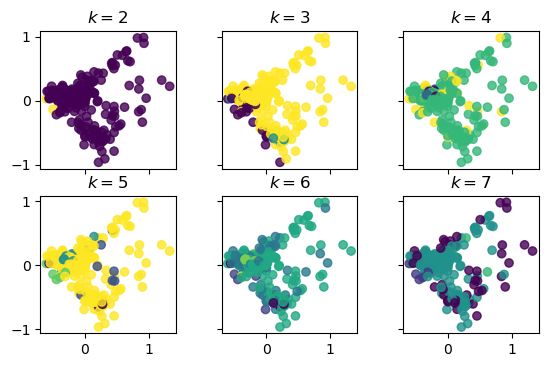

In [158]:
# Visualize SV2 vs. SV3
plot_clusters(X_new, cluster_res['ys'], x_num=2, y_num=3);

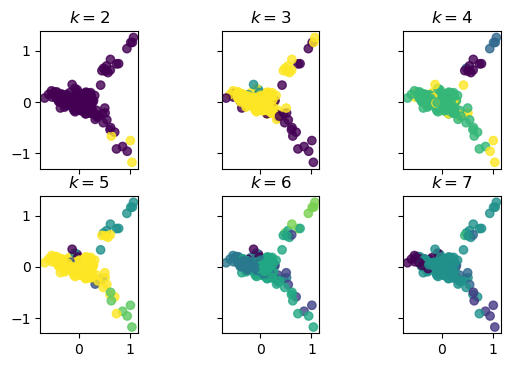

In [159]:
# Visualize SV4 vs. SV5
plot_clusters(X_new, cluster_res['ys'], x_num=4, y_num=5);

### Plot validation metrics

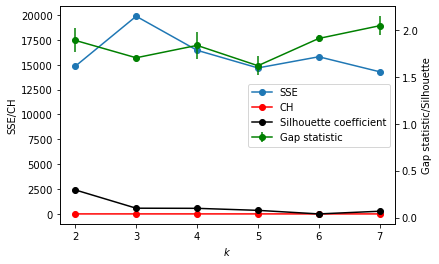

In [161]:
plot_internal(cluster_res['inertias'],
              cluster_res['chs'],
              cluster_res['scs'],
              cluster_res['gss'],
              cluster_res['gssds']);

# Hierarchical Clustering

In [171]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

# Wards

### Perform clustering on transformed matrix

In [177]:
Z = linkage(X_new, method='ward', optimal_ordering=True)

### Choose cut-off point

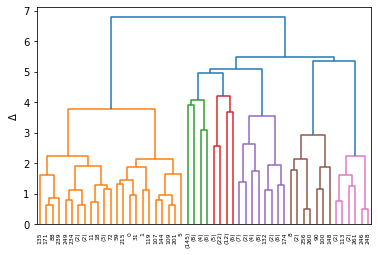

In [175]:
fix_dendro(Z);

### Plot clusters
Interpretation will change depending on the chosen SVs to plot

In [ ]:
# 4.5 based on dendrogram
y_predict = fcluster(Z, t=4.5, criterion='distance')

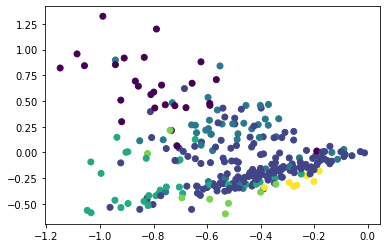

In [178]:
# Visualize SV1 vs. SV2
x_num = 1
y_num = 2
plt.scatter(X_new[:,(x_num-1)], X_new[:,(y_num-1)], c=y_predict);

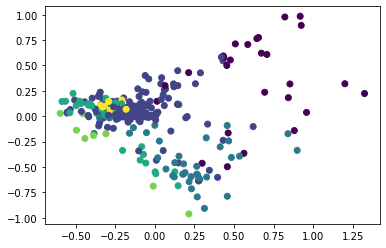

In [179]:
# Visualize SV2 vs. SV3
x_num = 2
y_num = 3
plt.scatter(X_new[:,(x_num-1)], X_new[:,(y_num-1)], c=y_predict);

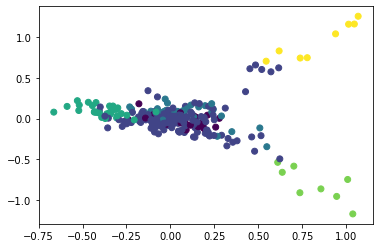

In [180]:
# Visualize SV4 vs. SV5
x_num = 4
y_num = 5
plt.scatter(X_new[:,(x_num-1)], X_new[:,(y_num-1)], c=y_predict);

# Complete

### Perform clustering on transformed matrix

In [181]:
Z = linkage(X_new, method='complete', optimal_ordering=True)

### Choose cut-off point

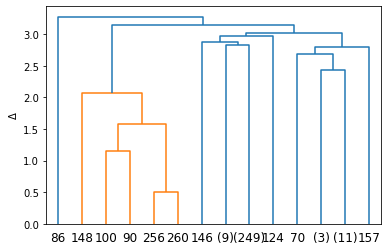

In [182]:
fix_dendro(Z);

### Plot clusters
Interpretation will change depending on the chosen SVs to plot

In [186]:
# 4.5 based on dendrogram
y_predict = fcluster(Z, t=3, criterion='distance')

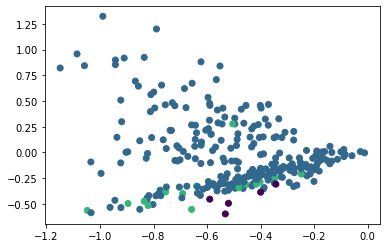

In [188]:
# Visualize SV1 vs. SV2
x_num = 1
y_num = 2
plt.scatter(X_new[:,(x_num-1)], X_new[:,(y_num-1)], c=y_predict);

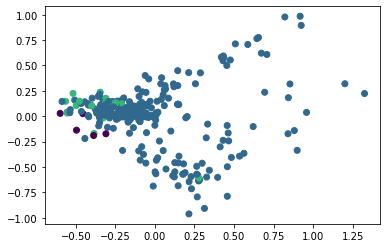

In [189]:
# Visualize SV2 vs. SV3
x_num = 2
y_num = 3
plt.scatter(X_new[:,(x_num-1)], X_new[:,(y_num-1)], c=y_predict);

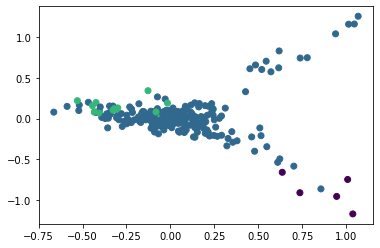

In [190]:
# Visualize SV4 vs. SV5
x_num = 4
y_num = 5
plt.scatter(X_new[:,(x_num-1)], X_new[:,(y_num-1)], c=y_predict);